In [1]:
from google.colab import files
uploaded = files.upload()

Saving News.csv to News.csv


In [6]:
import pandas as pd
import nltk

df = pd.read_csv('News.csv')
print("Original dataset shape:", df.shape)
df.head()

Original dataset shape: (12520, 2)


,text,label
0,sing praise mahinda lose voice sri lanka disro...,1
1,kojc rally first time davao city appoint son god,1
2,bill gate people resist mrna tsunami exclude s...,1
3,cure covid19 forward budesonide asthma drug pl...,1
4,president trump form patriot party 81 day elec...,1


In [7]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [8]:
import re
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk



stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t not in stop_words]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return ' '.join(tokens)

df['clean_text'] = df['text'].apply(preprocess_text)


# **Bag of Words Features**

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(
    stop_words='english',
    max_df=0.95,
    min_df=5,
    max_features=5000,
    ngram_range=(1, 2)
)

X = vectorizer.fit_transform(df['clean_text'])


**Logistic Regression**


Best Hyperparameters: {'clf__C': 0.1, 'clf__penalty': 'l2'}
Training Accuracy: 0.9433
Testing Accuracy: 0.9058
Recall: 0.9249
F1 Score: 0.9164
AUC Score: 0.9713

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.88      0.89      1105
           1       0.91      0.92      0.92      1399

    accuracy                           0.91      2504
   macro avg       0.91      0.90      0.90      2504
weighted avg       0.91      0.91      0.91      2504



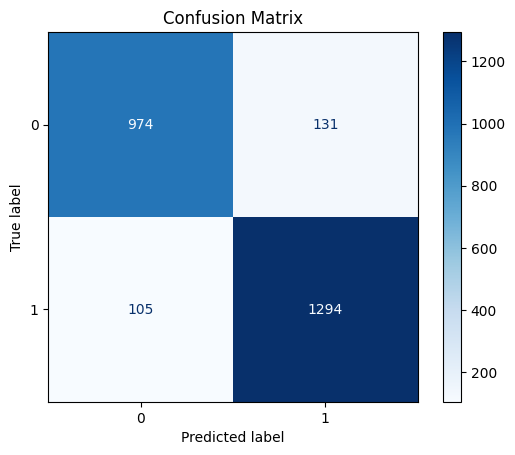

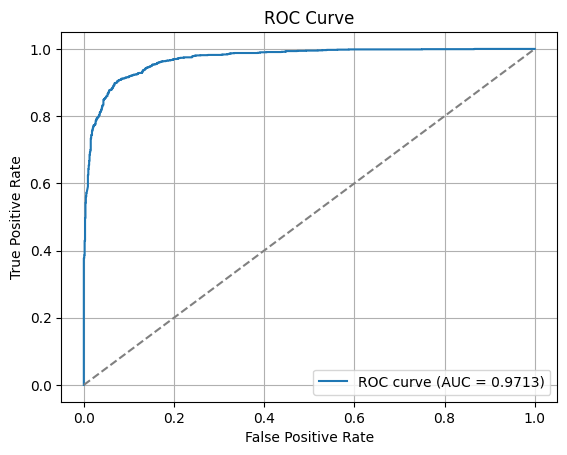

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    accuracy_score, recall_score, f1_score,
    roc_auc_score, classification_report,
    confusion_matrix, roc_curve, ConfusionMatrixDisplay
)
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt


vectorizer = CountVectorizer(
    stop_words='english',
    max_df=0.9,
    min_df=5,
    max_features=3000,
    ngram_range=(1, 2)
)

X_vec = vectorizer.fit_transform(df['clean_text'])
X_train, X_test, y_train, y_test = train_test_split(
    X_vec, df['label'], test_size=0.2, stratify=df['label'], random_state=42
)


pipeline = Pipeline([
    ('selector', SelectKBest(chi2, k=1500)),
    ('clf', LogisticRegression(solver='liblinear', max_iter=1000, class_weight='balanced'))
])

param_grid = {
    'clf__C': [0.001, 0.01, 0.1],
    'clf__penalty': ['l1', 'l2']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=10, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
train_preds = best_model.predict(X_train)
test_preds = best_model.predict(X_test)
test_probs = best_model.predict_proba(X_test)[:, 1]

train_acc = accuracy_score(y_train, train_preds)
test_acc = accuracy_score(y_test, test_preds)
recall = recall_score(y_test, test_preds)
f1 = f1_score(y_test, test_preds)
auc = roc_auc_score(y_test, test_probs)

print("Best Hyperparameters:", grid_search.best_params_)
print(f"Training Accuracy: {train_acc:.4f}")
print(f"Testing Accuracy: {test_acc:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC Score: {auc:.4f}")
print("\nClassification Report:\n", classification_report(y_test, test_preds))

cm = confusion_matrix(y_test, test_preds)
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

fpr, tpr, _ = roc_curve(y_test, test_probs)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


**Naive Bayes**

Best alpha: 0.7
Naive Bayes → Training Accuracy: 0.9240
Naive Bayes → Testing Accuracy: 0.9069
Recall: 0.8985
F1 Score: 0.9152
AUC Score: 0.9654

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.92      0.90      1105
           1       0.93      0.90      0.92      1399

    accuracy                           0.91      2504
   macro avg       0.90      0.91      0.91      2504
weighted avg       0.91      0.91      0.91      2504



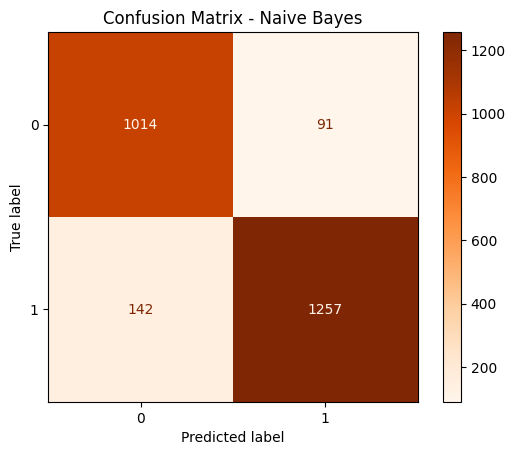

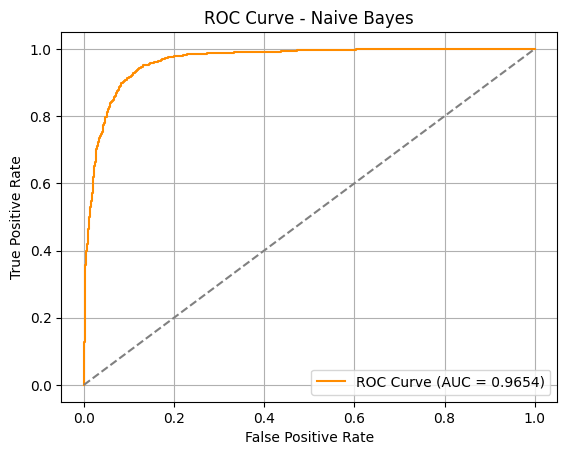

In [11]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve
)
import matplotlib.pyplot as plt

pipeline = Pipeline([
    ('selector', SelectKBest(chi2, k=3000)),
    ('nb', MultinomialNB())
])


param_grid = {
    'nb__alpha': [0.1, 0.3, 0.5, 0.7, 1.0]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=10, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
X_train_sel = best_model.named_steps['selector'].transform(X_train)
X_test_sel = best_model.named_steps['selector'].transform(X_test)

train_preds = best_model.predict(X_train)
test_preds = best_model.predict(X_test)
test_probs = best_model.predict_proba(X_test)[:, 1]

train_acc = accuracy_score(y_train, train_preds)
test_acc = accuracy_score(y_test, test_preds)
recall = recall_score(y_test, test_preds)
f1 = f1_score(y_test, test_preds)
auc = roc_auc_score(y_test, test_probs)

print("Best alpha:", grid_search.best_params_['nb__alpha'])
print(f"Naive Bayes → Training Accuracy: {train_acc:.4f}")
print(f"Naive Bayes → Testing Accuracy: {test_acc:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC Score: {auc:.4f}")
print("\nClassification Report:\n", classification_report(y_test, test_preds))

cm = confusion_matrix(y_test, test_preds)
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap=plt.cm.Oranges)
plt.title("Confusion Matrix - Naive Bayes")
plt.show()

fpr, tpr, _ = roc_curve(y_test, test_probs)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.4f})", color='darkorange')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Naive Bayes")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


**Support Vector Machine**



SVM (Linear, C=0.1) → Training Accuracy: 0.9570, Testing Accuracy: 0.9149
Recall: 0.9392
F1 Score: 0.9250
AUC Score: 0.9746

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.88      0.90      1105
           1       0.91      0.94      0.93      1399

    accuracy                           0.91      2504
   macro avg       0.92      0.91      0.91      2504
weighted avg       0.92      0.91      0.91      2504



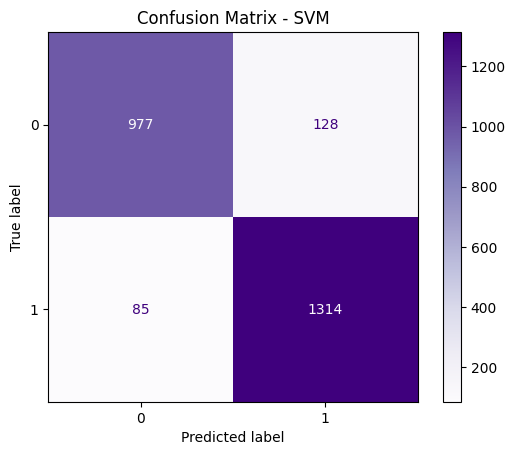

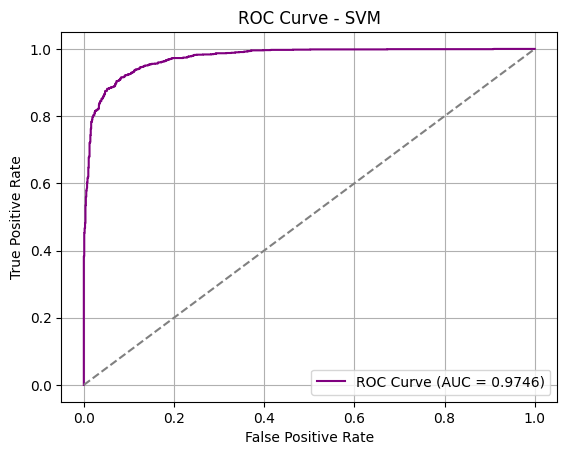

In [12]:
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import (
    accuracy_score, recall_score, f1_score,
    roc_auc_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay, roc_curve
)
import matplotlib.pyplot as plt


selector = SelectKBest(chi2, k=2000)
X_train_sel = selector.fit_transform(X_train, y_train)
X_test_sel = selector.transform(X_test)


svm = SVC(C=0.1, kernel='linear', probability=True)
svm.fit(X_train_sel, y_train)

train_preds = svm.predict(X_train_sel)
test_preds = svm.predict(X_test_sel)
test_probs = svm.predict_proba(X_test_sel)[:, 1]

train_acc = accuracy_score(y_train, train_preds)
test_acc = accuracy_score(y_test, test_preds)
recall = recall_score(y_test, test_preds)
f1 = f1_score(y_test, test_preds)
auc = roc_auc_score(y_test, test_probs)

print(f"SVM (Linear, C=0.1) → Training Accuracy: {train_acc:.4f}, Testing Accuracy: {test_acc:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC Score: {auc:.4f}")
print("\nClassification Report:\n", classification_report(y_test, test_preds))

cm = confusion_matrix(y_test, test_preds)
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap=plt.cm.Purples)
plt.title("Confusion Matrix - SVM")
plt.show()

fpr, tpr, _ = roc_curve(y_test, test_probs)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.4f})", color='purple')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - SVM")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


**Gradient Boosting**

Fitting 5 folds for each of 108 candidates, totalling 540 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [22:55:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.8}

XGBoost Model Performance:
 Training Accuracy: 0.9240
 Testing Accuracy: 0.8966
 Recall: 0.9421
 F1 Score: 0.9105
 AUC Score: 0.9601

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.84      0.88      1105
           1       0.88      0.94      0.91      1399

    accuracy                           0.90      2504
   macro avg       0.90      0.89      0.89      2504
weighted avg       0.90      0.90      0.90      2504



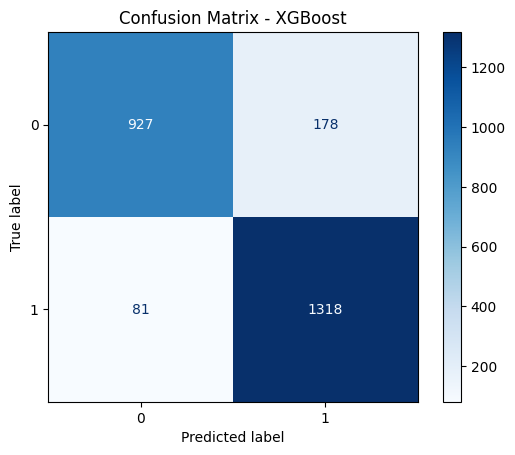

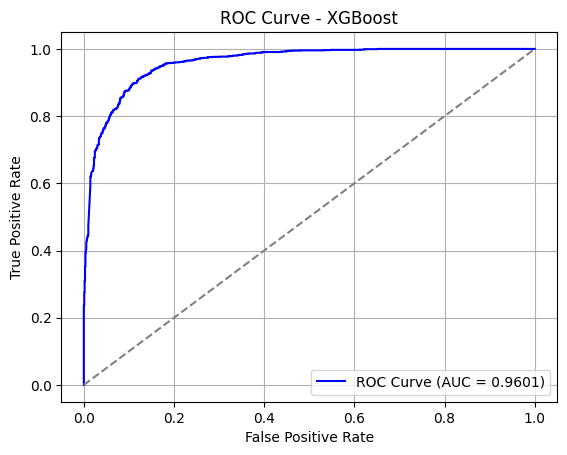

In [16]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    accuracy_score, recall_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve
)
import matplotlib.pyplot as plt


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}


xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
grid = GridSearchCV(xgb, param_grid=params, scoring='accuracy', cv=5, n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)


best_model = grid.best_estimator_
print("Best Parameters:", grid.best_params_)


train_preds = best_model.predict(X_train)
test_preds = best_model.predict(X_test)
test_probs = best_model.predict_proba(X_test)[:, 1]


train_acc = accuracy_score(y_train, train_preds)
test_acc = accuracy_score(y_test, test_preds)
recall = recall_score(y_test, test_preds)
f1 = f1_score(y_test, test_preds)
auc = roc_auc_score(y_test, test_probs)

print(f"\nXGBoost Model Performance:")
print(f" Training Accuracy: {train_acc:.4f}")
print(f" Testing Accuracy: {test_acc:.4f}")
print(f" Recall: {recall:.4f}")
print(f" F1 Score: {f1:.4f}")
print(f" AUC Score: {auc:.4f}")
print("\nClassification Report:\n", classification_report(y_test, test_preds))


cm = confusion_matrix(y_test, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - XGBoost")
plt.show()

fpr, tpr, _ = roc_curve(y_test, test_probs)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc:.4f})", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


**Auto Encoder**

Epoch 1/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.7760 - loss: 1.9222 - val_accuracy: 0.9311 - val_loss: 0.5297
Epoch 2/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9286 - loss: 0.5057 - val_accuracy: 0.9291 - val_loss: 0.5451
Epoch 3/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9381 - loss: 0.4816 - val_accuracy: 0.9092 - val_loss: 0.5762
Epoch 4/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9450 - loss: 0.4793 - val_accuracy: 0.9212 - val_loss: 0.5147
Epoch 5/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9501 - loss: 0.4507 - val_accuracy: 0.9232 - val_loss: 0.5714
Epoch 6/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9454 - loss: 0.4748 - val_accuracy: 0.9251 - val_loss: 0.5066
Epoch 7/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9543 - loss: 0.4345 - val_accuracy: 0.9172 - val_loss: 0.5306
Epoch 8/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9523 - loss: 0.4369 - val_accuracy: 0

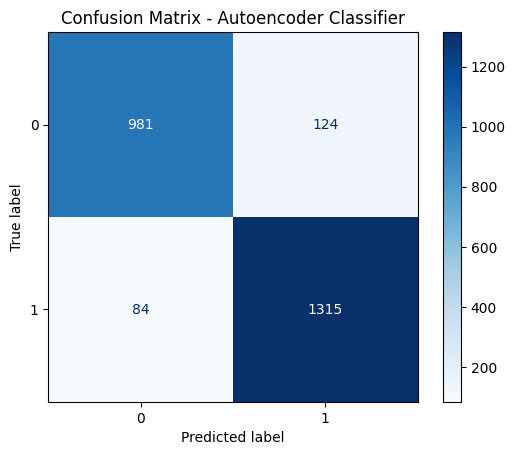

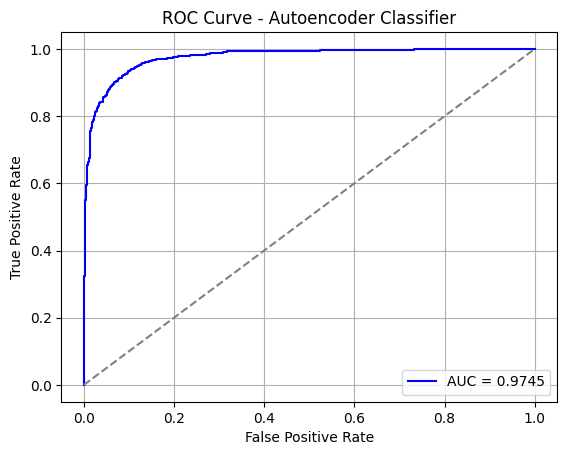

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, recall_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve
)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import numpy as np


X_dense = X.toarray()
y = df['label'].values


X_train, X_test, y_train, y_test = train_test_split(X_dense, y, test_size=0.2, stratify=y, random_state=42)


input_layer = Input(shape=(X.shape[1],))
encoded = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(input_layer)
encoded = Dropout(0.5)(encoded)
encoded = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(encoded)

decoded = Dense(256, activation='relu')(encoded)
decoded = Dropout(0.5)(decoded)

output = Dense(1, activation='sigmoid')(decoded)

model = Model(inputs=input_layer, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


model.fit(X_train, y_train, validation_split=0.1, epochs=20, batch_size=32, callbacks=[early_stop], verbose=1)


train_preds = (model.predict(X_train) > 0.5).astype(int)
test_preds = (model.predict(X_test) > 0.5).astype(int)
test_probs = model.predict(X_test)


train_acc = accuracy_score(y_train, train_preds)
test_acc = accuracy_score(y_test, test_preds)
recall = recall_score(y_test, test_preds)
f1 = f1_score(y_test, test_preds)
auc = roc_auc_score(y_test, test_probs)

print(f"\nAutoencoder-Based Classifier → Training Accuracy: {train_acc:.4f}, Testing Accuracy: {test_acc:.4f}")
print(f"Recall: {recall:.4f}, F1 Score: {f1:.4f}, AUC: {auc:.4f}")
print("\nClassification Report:\n", classification_report(y_test, test_preds))


cm = confusion_matrix(y_test, test_preds)
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Autoencoder Classifier")
plt.show()


fpr, tpr, _ = roc_curve(y_test, test_probs)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}", color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Autoencoder Classifier")
plt.legend()
plt.grid(True)
plt.show()


**Feed Forward Neural Network**

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 232s 815ms/step - accuracy: 0.7793 - loss: 1.4160 - val_accuracy: 0.9222 - val_loss: 0.5047
Epoch 2/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 107s 268ms/step - accuracy: 0.9173 - loss: 0.5065 - val_accuracy: 0.9222 - val_loss: 0.5056
Epoch 3/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 43s 130ms/step - accuracy: 0.9192 - loss: 0.4892 - val_accuracy: 0.9261 - val_loss: 0.4771
Epoch 4/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 31s 109ms/step - accuracy: 0.9247 - loss: 0.4775 - val_accuracy: 0.9142 - val_loss: 0.4771
Epoch 5/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 32s 71ms/step - accuracy: 0.9306 - loss: 0.4532 - val_accuracy: 0.9281 - val_loss: 0.4660
Epoch 6/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 16s 59ms/step - accuracy: 0.9361 - loss: 0.4460 - val_accuracy: 0.9261 - val_loss: 0.4586
Epoch 7/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 24s 72ms/step - accuracy: 0.9333 - loss: 0.4414 - val_accuracy: 0.9301 - val_loss: 0.4605
Epoch 8/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.9372 - loss: 0.4

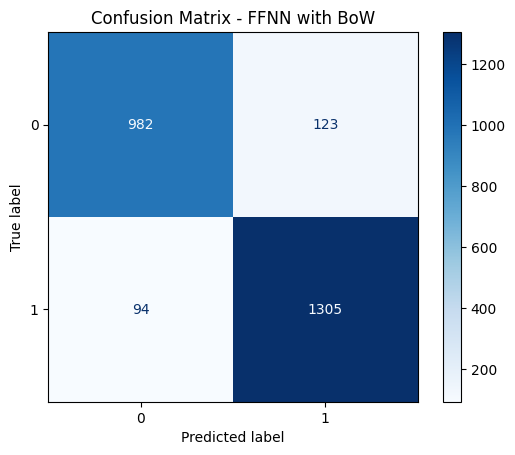

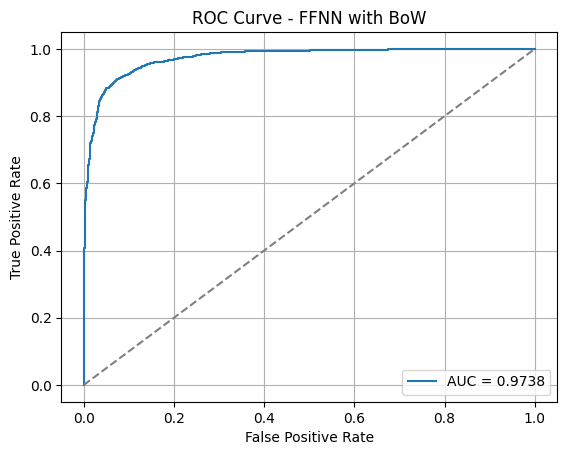

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, recall_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt


X_train, X_test, y_train, y_test = train_test_split(X, df['label'].values, test_size=0.2, stratify=df['label'], random_state=42)


model = Sequential([
    Dense(128, activation='relu', input_shape=(X.shape[1],), kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, callbacks=[early_stop], verbose=1)


train_preds = (model.predict(X_train) > 0.5).astype(int)
test_preds = (model.predict(X_test) > 0.5).astype(int)
test_probs = model.predict(X_test)

train_acc = accuracy_score(y_train, train_preds)
test_acc = accuracy_score(y_test, test_preds)
recall = recall_score(y_test, test_preds)
f1 = f1_score(y_test, test_preds)
auc = roc_auc_score(y_test, test_probs)

print(f"\nBoW FFNN → Training Accuracy: {train_acc:.4f}, Testing Accuracy: {test_acc:.4f}")
print(f"Recall: {recall:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")
print("\nClassification Report:\n", classification_report(y_test, test_preds))

cm = confusion_matrix(y_test, test_preds)
ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - FFNN with BoW")
plt.show()

fpr, tpr, _ = roc_curve(y_test, test_probs)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - FFNN with BoW")
plt.legend()
plt.grid(True)
plt.show()
